In [1]:
clean_up = True
%run stdPackages.ipynb
ws = gams.GamsWorkspace(working_directory=d['work']) # specify where you want to run the GAMS models from (here the repository referred to in d['work'])
d['data'] = os.path.join(d['data'], 'IO2018')

## SmallGR, exports

### Data/settings

Load data, settings:

In [2]:
name = 'smallGR' # name of model
module = name+'_Tr' # name of module
db_IO = GpyDB(pickle_path = os.path.join(d['data'], f'IO_{name}')) # load IO database named IO_name
with open(f"{d['data']}\\glob_{name}","rb") as file: # load global settings anmed glob_name
    glob=pickle.load(file)

Keep relevant data:

In [3]:
aggregateDB.subset_db(db_IO, db_IO.get('s_f')) # Keep data on relevant sectors

Add time index to the IO data:

In [4]:
def addT(symbol, t):
    return adjMultiIndex.bc(symbol, t).reorder_levels(['t']+symbol.index.names if 't' not in symbol.index.names else symbol.index.names)
[db_IO.__setitem__(k, addT(db_IO.get(k), glob.db['t'].vals)) for k in db_IO.getTypes(['variable','scalar_variable'])];

### Initialize module

Set up module, use IO database as input.

In [5]:
T = CGE_Trade.SimpleArmington(name = module, glob = glob, s_kwargs = {'db': db_IO},  kwargs = {'sfor_ndom': db_IO.get('dExport')})

Initialize, write, and solve:

In [6]:
T.compile(initDB=True);
T.s.setstate('C')
T.write();
m = T.run(exportTo = d['work'],ws=ws) # solve the "model".

Export:

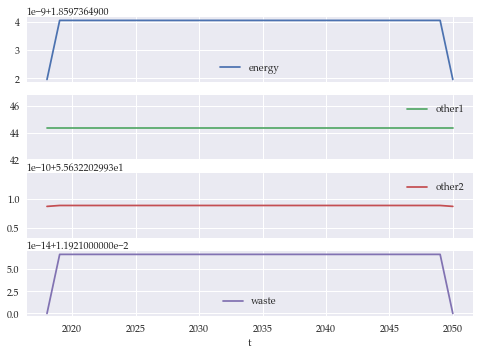

In [7]:
T.s.db = m.out_db
T.s.setstate('B')
T.get('qD').xs('F',level='s').unstack('n').plot(subplots=True, backend = "matplotlib");

In [8]:
with open(os.path.join(d['data'], T.name), "wb") as file:
    pickle.dump(T,file)